<a href="https://colab.research.google.com/github/Olga1252/My-practical-work-for-SF/blob/main/My_practice_for_SF_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install datasets torchvision torch pillow scikit-learn


In [11]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch
from datasets import load_dataset

In [12]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch
from datasets import load_dataset

# Загружаем датасет
dataset = load_dataset("Duo1111/Deforestation")

# Первая картинка
image = dataset["train"]["image"][0]

# Здесь мы загружаем процессор и ResNet-18
image_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-18")
model = AutoModelForImageClassification.from_pretrained(
    "microsoft/resnet-18",
    num_labels=2,
    ignore_mismatched_sizes=True
)

# Передаем нашу картинку без обучения
inputs = image_processor(image, return_tensors="pt")

# Затем получаем наш ответ
with torch.no_grad():
    logits = model(**inputs).logits

predicted_label = logits.argmax(-1).item()

print("Predict:", model.config.id2label[predicted_label])


Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-18 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 512]) in the checkpoint and torch.Size([2, 512]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predict: LABEL_0


In [13]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split

dataset = load_dataset("Duo1111/Deforestation")["train"]

# Делим на train/val split, где 80% на для обучения и 20% - для проверки
train_idx, val_idx = train_test_split(
    list(range(len(dataset))),
    test_size=0.2,
    random_state=42,
    shuffle=True
)

train_ds = dataset.select(train_idx)
val_ds   = dataset.select(val_idx)

print(len(train_ds), len(val_ds))


1608 402


In [14]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
#готовим версию обработки изображения, указываем картинки правильного размера
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

class ForestDataset(Dataset):
    def __init__(self, hf_ds):
        self.ds = hf_ds

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]
        img = transform(item["image"])
        label = item["label"]
        return img, torch.tensor(label).long()


In [15]:
from torch.utils.data import DataLoader

train_loader = DataLoader(ForestDataset(train_ds), batch_size=16, shuffle=True)
val_loader   = DataLoader(ForestDataset(val_ds), batch_size=16)


In [16]:
import torch.nn as nn
import torchvision.models as models
#Берем готовую модель Resnet
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # 2 класса: forest / deforestation
model = model.to(device)


Using device: cpu


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# настроили обучение

In [18]:
for epoch in range(5): # 5 кругов обучения
    model.train() # включаем
    total_loss = 0

    for imgs, labels in train_loader:# проходимся по картинкам
        imgs, labels = imgs.to(device), labels.to(device) # в данном случае ,у меня CPU

        optimizer.zero_grad() # сбрасываем старую ошибку
        outputs = model(imgs) # модель делает предсказание
        loss = criterion(outputs, labels) #Считает ошибку
        loss.backward() # градиент, куда двигаемся
        optimizer.step() # оптимизируем

        total_loss += loss.item() #накапливаем loss

    # Валидация
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item() # подсчитываем процент верных ответов
            total += labels.size(0)

    acc = correct / total
    print(f"Epoch {epoch+1}: Loss={total_loss:.3f}, Val Acc={acc:.3f}")


Epoch 1: Loss=12.609, Val Acc=0.983
Epoch 2: Loss=4.734, Val Acc=0.990
Epoch 3: Loss=2.598, Val Acc=0.993
Epoch 4: Loss=1.588, Val Acc=0.990
Epoch 5: Loss=1.584, Val Acc=0.978


Prediction: deforestation


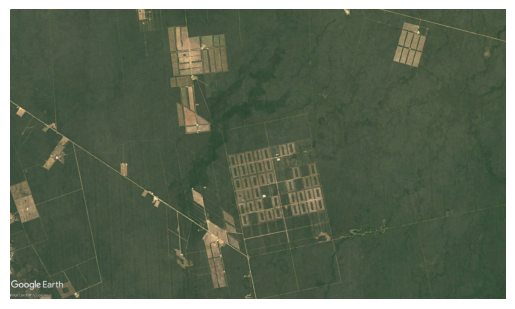

In [23]:
from PIL import Image
import matplotlib.pyplot as plt

idx = 228  #номер снимка
image = dataset[idx]["image"] # берем картинку из датасета

plt.imshow(image)
plt.axis("off")

img_tensor = transform(image).unsqueeze(0).to(device)

with torch.no_grad(): #отключаем обучение
    output = model(img_tensor)
    pred = torch.argmax(output, dim=1).item() # получаем класс

label_map = {1: "forest", 0: "deforestation"}
print("Prediction:", label_map[pred])
